# MLP for Dataset Version 3 (Dimension Reduction) + Optimized Hyperparameter

1. Import Necessary Libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import optuna
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.callback.schedule import lr_find
from fastai.optimizer import Adam

2. Preparing Data:

In [ ]:
data = pd.read_csv("DataVersion3.csv")

In [ ]:
data.shape

(25794, 17)

In [ ]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [ ]:
data_reduced_dim.shape

(25794, 50)

In [ ]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X.shape

(25794, 50)

In [ ]:
data = np.load('data_splits_v8.npz')
train_indices = data['train_indices']
val_indices = data['val_indices']
test_indices = data['test_indices']

X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]
X_test = X[test_indices]
y_test = y[test_indices]


In [ ]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

# Load the saved DataLoader objects
BATCH_SIZE = 32
train_loader, val_loader, test_loader = torch.load(f'dataloaders_{BATCH_SIZE}_v8.pt')

In [ ]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [ ]:
layer_sizes = [50]

hidden_layer_sizes = [49, 61, 61] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes)

optimizer = optim.Adam(model.parameters(), lr = 0.002875959500670433, weight_decay = 7.412033842835223e-05)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [ ]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
        all_targets = np.vstack((all_targets, targets.cpu().numpy()))

# Flatten arrays to 1D
all_preds = all_preds.flatten()
all_targets = all_targets.flatten()

r2 = r2_score(all_targets, all_preds)
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)
mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100

print(f'R^2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

R^2 Score: 0.7299
RMSE: 1.1945
MAE: 0.5192
MAPE: 56.47%


In [ ]:
model.load_state_dict(torch.load(r"D:\fpt47\Downloads\Programming\Code\2023.2\ML\Mid-term Project\DataProcessing\Swarm Optimization\PSO_StandardData_mlp_model.pth"))

<All keys matched successfully>

In [ ]:
for p in model.parameters():
    print(p.data)

tensor([[ 2.3546e-03,  2.6020e-01, -2.2327e-01,  ...,  6.0298e-03,
          1.1590e-02,  9.6198e-04],
        [-7.1072e-02,  1.7940e-02, -4.8631e-03,  ..., -5.8391e-03,
         -7.3266e-03, -1.5393e-04],
        [-8.3621e-03,  1.5597e-02, -7.0529e-03,  ...,  8.1693e-02,
          7.5478e-02, -1.7486e-03],
        ...,
        [-2.5102e+00, -1.0314e-03,  5.3130e-02,  ..., -1.4035e-02,
         -2.5662e-03, -1.4523e-02],
        [ 1.7727e-02,  8.1410e-02,  2.5342e-02,  ..., -1.1871e-02,
         -6.9173e-04, -2.8296e-03],
        [ 7.7262e-01, -1.2927e+00, -1.5755e-01,  ...,  1.5665e-02,
          1.8525e-01, -1.9962e-02]])
tensor([-0.0100,  0.0424,  0.1836,  0.1144,  0.0290,  0.0373, -0.0338,  0.0128,
         0.1158,  0.0381, -0.1808,  0.0032, -0.1353,  0.0837,  0.0379,  0.0384,
        -0.0004,  0.1850,  0.1223, -0.0014, -0.0080, -0.0110,  0.0337, -0.0438,
         0.0066, -0.0087, -0.0074,  0.0070,  0.0623, -0.0069, -0.0118, -0.0213,
        -0.0031, -0.0061, -0.0064, -0.0008, -0.0

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=50, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=61, bias=True)
    (3): ReLU()
    (4): Linear(in_features=61, out_features=61, bias=True)
    (5): ReLU()
    (6): Linear(in_features=61, out_features=1, bias=True)
  )
)

In [ ]:
for p in model.parameters():
    print(p.data)

tensor([[-0.0155,  0.1159,  0.0049,  ...,  0.0461, -0.0716, -0.0178],
        [ 0.0704,  0.0343, -0.0184,  ...,  0.1004,  0.1152, -0.1267],
        [-0.1323,  0.1054,  0.0497,  ...,  0.0297,  0.1053,  0.0885],
        ...,
        [-0.0795,  0.1213,  0.1180,  ...,  0.0823, -0.1069,  0.1328],
        [ 0.1216,  0.0926, -0.0304,  ...,  0.1016, -0.0647, -0.0490],
        [-0.0992,  0.0239,  0.1259,  ...,  0.1140, -0.0882,  0.0364]],
       device='cuda:0')
tensor([ 0.0995,  0.0720, -0.0022,  0.0191,  0.0600, -0.1191,  0.0222, -0.1391,
        -0.0895,  0.1086,  0.0588, -0.0060,  0.1213, -0.0085, -0.1150,  0.1410,
         0.0971, -0.0485,  0.0461,  0.1322, -0.0268,  0.1401,  0.1191,  0.0372,
        -0.1348,  0.0979, -0.1169, -0.0921,  0.1389,  0.0734,  0.0974,  0.0171,
        -0.0266, -0.0279,  0.0144, -0.0706,  0.1353,  0.1285, -0.1371, -0.0141,
         0.1156, -0.0475, -0.0575, -0.0200, -0.0724, -0.1412,  0.1371,  0.0518,
         0.1186], device='cuda:0')
tensor([[-0.0347, -0.0132, 

Epoch [1/120], Loss: 0.5234, Val Loss: 0.8776
Epoch [2/120], Loss: 1.6499, Val Loss: 0.7562
Epoch [3/120], Loss: 0.4592, Val Loss: 0.7117
Epoch [4/120], Loss: 0.0829, Val Loss: 0.8044
Epoch [5/120], Loss: 0.9992, Val Loss: 1.0229
Epoch [6/120], Loss: 0.1562, Val Loss: 0.6913
Epoch [7/120], Loss: 0.3738, Val Loss: 1.0315
Epoch [8/120], Loss: 0.2236, Val Loss: 0.6568
Epoch [9/120], Loss: 0.7465, Val Loss: 0.6761
Epoch [10/120], Loss: 0.0772, Val Loss: 0.6766
Epoch [11/120], Loss: 0.0581, Val Loss: 0.7303
Epoch [12/120], Loss: 0.9545, Val Loss: 0.6112
Epoch [13/120], Loss: 0.1210, Val Loss: 0.6060
Epoch [14/120], Loss: 0.3264, Val Loss: 0.6188
Epoch [15/120], Loss: 0.3937, Val Loss: 0.6548
Epoch [16/120], Loss: 0.8503, Val Loss: 0.6387
Epoch [17/120], Loss: 0.3848, Val Loss: 1.1160
Epoch [18/120], Loss: 0.1945, Val Loss: 0.6454
Epoch [19/120], Loss: 0.0889, Val Loss: 0.9119
Epoch [20/120], Loss: 0.2159, Val Loss: 0.6120
Epoch [21/120], Loss: 0.4522, Val Loss: 0.5922
Epoch [22/120], Loss: 

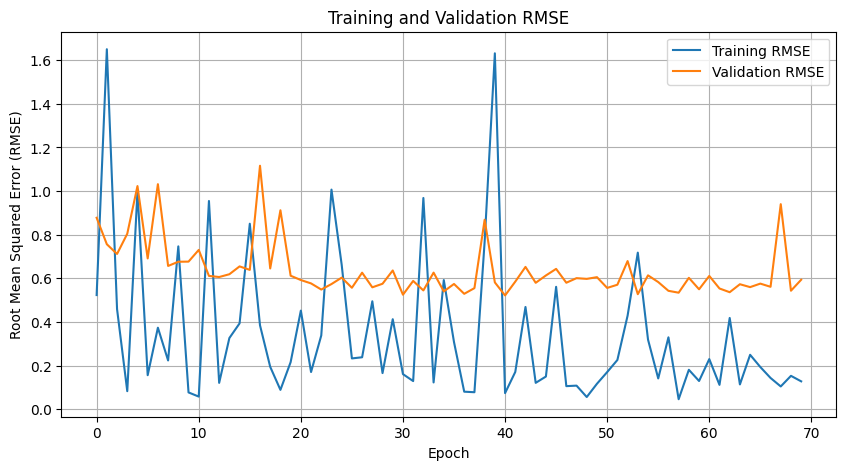

In [ ]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 30
num_epochs = 120
with open("result.txt", "a") as f:
    f.write(f"Using optimizer: {optimizer.__class__.__name__}" + "\n")
    f.write("With PSO (1470 iter) initialization")
    f.write("Standard data" + "\n")
    f.write("Optimized hyperparameter at Trial 576 finished with value: 0.2586706328428974 \
            and parameters: {'weight_decay': 7.412033842835223e-05, 'batch_size': 32, 'n_units_l1': 49, 'n_units_l2': 61, 'n_units_l3': 61}.\
            Suggested LR = 0.002875959500670433" + '\n')
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')
    f.write(f'MAPE: {mape:.2f}%' + '\n')

R^2 Score: 0.9182
RMSE: 0.6573
MAE: 0.2057
MAPE: 16.02%


In [ ]:
# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

In [ ]:
# Evaluate the model
def evaluate_model(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    val_loss /= len(val_loader)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    return val_loss, r2, rmse, mae, mape

In [ ]:
def find_best_lr(model, dls, criterion, weight_decay, device, max_attempts=5, start_lr=1e-6, end_lr=3, num_it=500):
    best_lr = None
    best_progress = 0

    for attempt in range(max_attempts):

        learn = Learner(dls, model, loss_func=criterion, opt_func=Adam, wd=weight_decay)

        try:
            # Use the learning rate finder without plotting
            lr_find_result = learn.lr_find(start_lr=start_lr, end_lr=end_lr, num_it=num_it, show_plot=False)

            # Calculate the number of valid iterations
            valid_losses = [loss for loss in learn.recorder.losses if not torch.isnan(loss) and loss < 500]
            progress = len(valid_losses)

            # Check if this attempt has the highest progress
            if progress > best_progress:
                best_progress = progress
                best_lr = lr_find_result.valley if progress > 0 else best_lr
            elif (progress == best_progress) and (progress > 0):
                suggest_lr = lr_find_result.valley
                if ((suggest_lr < best_lr) and (suggest_lr > 1e-3)) or ((best_lr < 1e-4) and (best_lr < suggest_lr) and (suggest_lr < 0.025)):
                        best_lr = suggest_lr
                    
            print(f"Attempt {attempt + 1}/{max_attempts}: Suggested LR = {lr_find_result.valley if progress > 0 else 'N/A'}, Valid Iterations = {progress}")

        except Exception as e:
            print(f"Attempt {attempt + 1}/{max_attempts} failed: {e}")
            continue

    if best_lr is None:
        best_lr = 1e-3  # Default learning rate if all attempts fail

    return best_lr


In [ ]:
# Wrap the DataLoader in a DataLoaders object
dls = DataLoaders(train_loader, train_loader)

In [ ]:
# Objective function for Optuna
def objective(trial, X_train, y_train, X_val, y_val, input_size, output_size, device, model = model):
    #Hyperparameters
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1, log = True)

    # Create data loaders
    train_loader, val_loader, test_loader = torch.load(f'dataloaders_{BATCH_SIZE}_v8.pt')
    criterion = nn.MSELoss()
    
    best_lr = find_best_lr(model, dls, criterion, weight_decay, device)
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
    
    # Train model
    train_model(model, train_loader, criterion, optimizer, num_epochs=30, device=device)
    
    # Evaluate model
    val_loss, r2, rmse, mae, mape = evaluate_model(model, criterion, val_loader, device)
    trial.set_user_attr("r2", r2)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("mape", mape)
    
    return val_loss